In [1]:
with open('libraries.py') as f:
    code = f.read()
exec(code)

with open('functions.py') as f:
    code = f.read()
exec(code)

In [2]:
# libraries
import os
import getpass
import glob
import numpy as np
import pandas as pd
import random
import networkx as nx
import requests
import re
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.reset_option('all')
pd.set_option('display.max_rows', 100)

In [3]:
# determine user
user = getpass.getuser()
if user == 'peymanshahidi':
    main_folder_path = '/Users/peymanshahidi/Dropbox (MIT)/Research/AI and Occupations/ai-exposure'
    data_path = f'{main_folder_path}/output'

In [4]:
occupation = 'travelAgents'
# occupation = 'insuranceAppraisersForAutoDamage'
# occupation = 'insuranceUnderwriters'
# occupation = 'pileDriverOperators'
# occupation = 'floorSandersAndFinishers'
# occupation = 'dataEntryKeyer' 
occupation = 'audiovisualEquipmentInstallerAndRepairers'

# Generate occupation-specific strings
GPT_input_occupation, plot_title_occupation, occupation_code, occupation_folder = pick_occupation(occupation)

In [5]:
# set alpha as AI quality measure
epsilon = 1e-8
# alpha_list = [epsilon*5e4, epsilon*1e5, epsilon*5e5, epsilon*1e6, epsilon*5e6, 0.1, 0.2, 0.3, 0.4, 0.5]
alpha_list = [epsilon*5e5, epsilon*7.5e5, epsilon*1e6, epsilon*2.5e6, epsilon*5e6, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1-epsilon]

### Initialize input-output paths

In [6]:
# # initialize inputs
# occupation = 'travelAgents'
# task_stats_input_path = 'travelAgents_taskStats.csv'

# DAG_type = 'FLT' # for First-Last-Task version
# # DAG_type = 'M' # for Manual version

In [7]:
# if DAG_type == 'FLT':
#     input_path = f'travelAgents_FLT_GPT_DAG_df.csv'
#     plot_title_occupation = 'Travel Agents: First-Last-Task DAG'
# elif DAG_type == 'M':
#     input_path = 'travelAgents_M_DAG_df.csv'
#     plot_title_occupation = 'Travel Agents: Manual DAG'

In [8]:
# Manual DAG
# input_path = f'{occupation_folder}/{occupation}_M_DAG_df.csv'

# First Last Task DAG
input_path = f'{occupation_folder}/{occupation}_FLT_GPT_DAG_df.csv'

# # Conditioned First Last Task DAG
# input_path = f'{occupation_folder}/{occupation}_CFLT_GPT_DAG_df.csv'

# # Partitioned DAG
# input_path = f'{occupation_folder}/{occupation}_P_GPT_DAG_df.csv'

# # Conditioned Partitioned DAG
# input_path = f'{occupation_folder}/{occupation}_CP_GPT_DAG_df.csv'


task_stats_input_path = f'{occupation_folder}/{occupation}_taskStats.csv'

In [9]:
# read DAG
dag_df = pd.read_csv(input_path)

# remove edges if comment column labeled with "TriangleRemovedFlag" 
# (those edges are there for DAG plotting purposes and are not part of the actual DAG)
if 'comment' in dag_df.columns:
    dag_df = dag_df[~dag_df['comment'].str.endswith('TriangleRemovedFlag')]

dag_df

,source,target,comment
0,"Install, service, and repair electronic equipm...",Compute cost estimates for labor and materials.,The worker computing cost estimates for labor ...
1,Disassemble entertainment equipment and repair...,Compute cost estimates for labor and materials.,The worker computing cost estimates for labor ...
2,Disassemble entertainment equipment and repair...,Keep records of work orders and test and maint...,The worker keeping records of work orders and ...
3,"Calibrate and test equipment, and locate circu...",Tune or adjust equipment and instruments to ob...,The worker tuning or adjusting equipment needs...
4,Disassemble entertainment equipment and repair...,Instruct customers on the safe and proper use ...,The worker instructing customers on the safe a...
5,"Install, service, and repair electronic equipm...","Calibrate and test equipment, and locate circu...",The worker calibrating and testing equipment n...
6,Confer with customers to determine the nature ...,"Install, service, and repair electronic equipm...","The worker installing, servicing, and repairin..."
7,Disassemble entertainment equipment and repair...,Tune or adjust equipment and instruments to ob...,The worker tuning or adjusting equipment needs...
8,Disassemble entertainment equipment and repair...,"Calibrate and test equipment, and locate circu...",The worker calibrating and testing equipment n...
9,Read and interpret electronic circuit diagrams...,"Install, service, and repair electronic equipm...","The worker installing, servicing, and repairin..."


In [10]:
# get task stats and create a list of tasks
tasks_stats = pd.read_csv(task_stats_input_path)
tasks_list = tasks_stats['task'].unique()

# set machine cost to 1 for all tasks except "Target" task
tasks_stats.loc[tasks_stats.index[:-1], 'machine_cost'] = 1 
tasks_stats

,task,human_cost,management_cost,management_difficulty,machine_cost,completion_difficulty
0,Disassemble entertainment equipment and repair...,60,15,0.75,1,0.65
1,"Install, service, and repair electronic equipm...",60,10,0.75,1,0.75
2,"Calibrate and test equipment, and locate circu...",60,30,0.75,1,0.75
3,Confer with customers to determine the nature ...,30,5,0.75,1,0.75
4,Tune or adjust equipment and instruments to ob...,30,10,0.75,1,0.75
5,Instruct customers on the safe and proper use ...,30,15,0.75,1,0.75
6,Compute cost estimates for labor and materials.,60,10,0.65,1,0.75
7,Read and interpret electronic circuit diagrams...,45,30,0.75,1,0.85
8,Keep records of work orders and test and maint...,30,10,0.25,1,0.25
9,Make service calls to repair units in customer...,120,30,0.75,1,0.75


In [11]:
# create a dictionary for indexing tasks later
tasks_dict = {i: node for i, node in enumerate(tasks_list, start=0)}

# create adjacency matrix in form of numpy array
adjacency_matrix = np.zeros((len(tasks_list), len(tasks_list)), dtype=int)
aux_dict = {value: key for key, value in tasks_dict.items()}
for _, row in dag_df.iterrows():
    source_index = aux_dict[row['source']]
    target_index = aux_dict[row['target']]
    adjacency_matrix[source_index, target_index] = 1
tasks_dict

{0: 'Disassemble entertainment equipment and repair or replace loose, worn, or defective components and wiring, using hand tools and soldering irons.',
 1: 'Install, service, and repair electronic equipment or instruments such as televisions, radios, and videocassette recorders.',
 2: 'Calibrate and test equipment, and locate circuit and component faults, using hand and power tools and measuring and testing instruments such as resistance meters and oscilloscopes.',
 3: 'Confer with customers to determine the nature of problems or to explain repairs.',
 4: 'Tune or adjust equipment and instruments to obtain optimum visual or auditory reception, according to specifications, manuals, and drawings.',
 5: 'Instruct customers on the safe and proper use of equipment.',
 6: 'Compute cost estimates for labor and materials.',
 7: 'Read and interpret electronic circuit diagrams, function block diagrams, specifications, engineering drawings, and service manuals.',
 8: 'Keep records of work orders 

In [12]:
# add task_dict key and reset index
aux_dict = {value: key for key, value in tasks_dict.items()}
tasks_stats['dict_index'] = tasks_stats.apply(lambda row: aux_dict[row.task], axis=1)
tasks_stats = tasks_stats.sort_values(by='dict_index')
tasks_stats = tasks_stats.set_index('dict_index', drop=False)
tasks_stats.index.name = None

In [13]:
# Create dictionaries for each of the five input parameters
# 1) human labor
human_labor_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['human_cost']))

# 2) machine automation (parameter C in model)
machine_automation_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['machine_cost']))

# 3) machine management (parameter D in model)
machine_management_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['management_cost']))

# 4) automation difficulty (parameter D_c in model)
automation_difficulty_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['completion_difficulty']))

# 5) management difficulty (parameter D_d in model)
management_difficulty_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['management_difficulty']))

### Generate all possible execution plans excluding the "Target" task (ignoring structre of the DAG)

In [14]:
def partitions(set_):
    if not set_:
        yield []
        return
    for i in range(1, len(set_) + 1):
        for part in itertools.combinations(set_, i):
            remaining = set(set_) - set(part)
            if not remaining:
                yield [list(part)]
            else:
                for b in partitions(list(remaining)):
                    yield [list(part)] + b

def generate_unique_partitions(numbers):
    all_execution_plans = set()
    for partition in partitions(numbers):
        # Create a frozenset of frozensets to make each partition hashable and order-independent
        partition_set = frozenset(frozenset(part) for part in partition)
        all_execution_plans.add(partition_set)
    
    # Convert the frozensets back to lists for the final output
    unique_partitions = [list(map(list, partition)) for partition in all_execution_plans]

    # Sort elements
    unique_partitions = sorted([sorted(x) for x in unique_partitions], key=len)
    
    return unique_partitions

In [15]:
# Generate list of numbers for non-Target tasks in occupation
tasks_list_numbers = list(range(len(tasks_list)-1)) # -1 for Target task: don't want to include it in task partitions as it's its own separate partition

# Generate all possible execution plans for N tasks
all_execution_plans = generate_unique_partitions(tasks_list_numbers)

# Print stats
print(f'Number of all possible execution plans: {len(all_execution_plans)}')

# print some partitions for sanity check 
print('\nExample execution plans:')
for plan in all_execution_plans[10:15]:
    print(plan)

Number of all possible execution plans: 678570

Example execution plans:
[[0, 1, 4, 7, 9], [2, 3, 5, 6, 8, 10]]
[[0, 1, 4, 7], [2, 3, 5, 6, 8, 9, 10]]
[[0, 5, 6], [1, 2, 3, 4, 7, 8, 9, 10]]
[[0, 2, 5], [1, 3, 4, 6, 7, 8, 9, 10]]
[[0, 1, 2, 6, 7, 8, 10], [9, 3, 4, 5]]


### Subset "valid" execution plans given DAG 
#### Validity criterion: non-singleton partitions should form a connected subgraph

In [16]:
def is_connected(matrix):
    # Number of nodes in the matrix
    num_nodes = matrix.shape[0]
    
    # Visited array to keep track of visited nodes
    visited = np.zeros(num_nodes, dtype=bool)
    
    # Helper function to perform DFS
    def dfs(node):
        visited[node] = True
        # Visit all the neighbors of the current node
        for neighbor in range(num_nodes):
            if matrix[node, neighbor] == 1 and not visited[neighbor]:
                dfs(neighbor)
            elif matrix[neighbor, node] == 1 and not visited[neighbor]:
                dfs(neighbor)
    
    # Start DFS from the first node (node 0)
    dfs(0)
    
    # If all nodes are visited, the matrix is connected
    return np.all(visited)

def validate_partition_using_connectedness(adjacency_matrix, tasks_list):
    # Return valid if Singleton
    if len(tasks_list) == 1:
        return True
    # Check if partition forms connected graph
    else:
        # Subset original adjacency matrix
        subset_matrix = adjacency_matrix[np.ix_(tasks_list, tasks_list)]

        # check if subset matrix is a connected graph
        subset_matrix_connected = is_connected(subset_matrix)

        # return true if connected and false otherwise
        return subset_matrix_connected

In [17]:
# Subset valid plans from set of all possible execution plans for given DAG
valid_execution_plans = []
for scheme in all_execution_plans:
    # Set valid partitions count to 0
    valid_partition_count = 0
    for partition in scheme:
        valid_partition = validate_partition_using_connectedness(adjacency_matrix, partition)
        if valid_partition:
            valid_partition_count += 1
    
    # If number of valid partitions within a execution plan is equal to 
    # number of partitions in execution plan then that execution plan is valid
    if valid_partition_count == len(scheme):
        valid_execution_plans.append(scheme)

# Print stats
print(f'Number of all possible execution plans: {len(all_execution_plans)}')
print(f'Number of valid execution plans given DAG: {len(valid_execution_plans)}')

# print some partitions for sanity check 
print('\nExample valid execution plans:')
for plan in valid_execution_plans[10:15]:
    print(plan)

Number of all possible execution plans: 678570
Number of valid execution plans given DAG: 223341

Example valid execution plans:
[[0, 1, 4, 7], [2, 3, 5, 6, 8, 9, 10]]
[[0, 5, 6], [1, 2, 3, 4, 7, 8, 9, 10]]
[[0, 2, 5], [1, 3, 4, 6, 7, 8, 9, 10]]
[[0, 1, 2, 6, 7, 8, 10], [9, 3, 4, 5]]
[[0, 10, 3, 7], [1, 2, 4, 5, 6, 8, 9]]


### Determine composition of tasks in execution plan. Proceed by determining:
1) automated tasks: those in partitions with length >2 that have no outgoing edges to nodes outside partition
2) human tasks: must be singleton task but not every singleton task is done by human
3) managed tasks: either singleton task that is not done by human or task on the inner boundary of partitions of length >2

<br>

First determine automated tasks.

In [18]:
def get_partition_boundary(adjacency_matrix, partition):
    # create a matrix whose columns are nodes not in the partition and whose rows are nodes in the partition
    # (subset adjacency matrix to outgoing edges of partition nodes --i.e., rows-- and incoming edges of non-partition nodes --i.e., columns.)
    reduced_matrix = np.delete(adjacency_matrix, partition, axis=1) 
    reduced_matrix = reduced_matrix[partition, :]

    # find nodes in partition w/ an edge to non-partition nodes
    partition_boundary_tasks = [i for i in partition if np.any(reduced_matrix[partition.index(i), :])]

    return partition_boundary_tasks

def get_automated_tasks(adjacency_matrix, execution_plan):
    # automated tasks only appear in partitions with at least two tasks in them
    # filter partitions with length >=2
    filtered_execution_plan = [partition for partition in execution_plan if len(partition) >= 2]

    # flatten filterd_execution_plan
    flattened_filtered_execution_plan = [task for partition in filtered_execution_plan for task in partition]

    # get tasks on the boundary given adjacency matrix and surviving partitions
    boundary_tasks_list = []
    for partition in filtered_execution_plan:
        # get partition boundary tasks
        partition_boundary_tasks = get_partition_boundary(adjacency_matrix, partition)
        boundary_tasks_list.extend(partition_boundary_tasks)

    # automated tasks are those that are in the flattened list but not in the boundary tasks list
    automated_tasks_list = list(set(flattened_filtered_execution_plan) - set(boundary_tasks_list))

    return sorted(automated_tasks_list)

In [19]:
automated_tasks_list = []
for execution_plan in valid_execution_plans:
    automated_tasks_list.append(get_automated_tasks(adjacency_matrix, execution_plan))

automated_tasks_df = pd.DataFrame({'execution_plan': valid_execution_plans,
                                   'automated_tasks': automated_tasks_list})
automated_tasks_df

,execution_plan,automated_tasks
0,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]","[0, 1, 2, 3, 4, 6, 7, 9]"
1,"[[0, 2, 3, 4, 6, 9], [1, 5, 7, 8, 10]]",[6]
2,"[[0, 2, 4, 5, 6, 7, 9, 10], [8, 1, 3]]",[6]
3,"[[0, 2, 3, 5, 8, 10], [1, 4, 6, 7, 9]]",[6]
4,"[[0, 2, 6, 7, 9], [1, 3, 4, 5, 8, 10]]","[4, 6]"
...,...,...
223336,"[[0], [1, 10], [2], [3], [4], [5], [6], [7], [...",[]
223337,"[[0], [1, 6], [2], [3], [4], [5], [7], [8], [9...",[]
223338,"[[0], [1], [2], [3], [4, 7], [5], [6], [8], [9...",[]
223339,"[[0], [1], [2, 5], [3], [4], [6], [7], [8], [9...",[]


### Account for singleton subset/partitions being done by either human or AI
Each singleton subset/partition in an execution plan can be done by either human or machine. For example, execution plan [[0], [1,2]] represents the following two plans: 
1) [1,2] done by AI and [0] done by human,
2) [1,2] and [0] done by AI.

<br>

#### Below generate full set of valid execution plans by considering different possibilities of doing singleton tasks.

In [20]:
# Create dataframe of all possible variations of doing valid execution plans
valid_execution_plans_df = pd.DataFrame()
for my_valid_execution_plan, my_automated_tasks in zip(valid_execution_plans, automated_tasks_list):
    # Get "singleton" partitions in valid execution plan
    singleton_partitions = [lst[0] for lst in my_valid_execution_plan if len(lst) == 1]

    # Get the power set of "singleton" partitions
    # The goal is to generate ways singleton tasks can be done by human or AI
    all_combinations = [[]]
    for r in range(1, len(singleton_partitions) + 1):
        combinations_r = itertools.combinations(singleton_partitions, r)
        all_combinations.extend(combinations_r)

    # Convert all_combinations to a list of lists
    all_combinations = [list(comb) for comb in all_combinations]

    # Repeat my_valid_partition for each combination in all_combinations to create a dataframe later
    my_valid_partition_repeated = [my_valid_execution_plan for _ in range(len(all_combinations))]
    my_automated_tasks_repeated = [my_automated_tasks for _ in range(len(all_combinations))]
    aux_df = pd.DataFrame({'execution_plan': my_valid_partition_repeated, 
                           'human_tasks': all_combinations,
                           'automated_tasks': my_automated_tasks_repeated})
    
    # Append to valid_execution_plans_df
    valid_execution_plans_df = pd.concat([valid_execution_plans_df, aux_df], ignore_index=True)

valid_execution_plans_df

,execution_plan,human_tasks,automated_tasks
0,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]",[],"[0, 1, 2, 3, 4, 6, 7, 9]"
1,"[[0, 2, 3, 4, 6, 9], [1, 5, 7, 8, 10]]",[],[6]
2,"[[0, 2, 4, 5, 6, 7, 9, 10], [8, 1, 3]]",[],[6]
3,"[[0, 2, 3, 5, 8, 10], [1, 4, 6, 7, 9]]",[],[6]
4,"[[0, 2, 6, 7, 9], [1, 3, 4, 5, 8, 10]]",[],"[4, 6]"
...,...,...,...
1691107,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...","[0, 1, 2, 4, 5, 6, 7, 8, 9, 10]",[]
1691108,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...","[0, 1, 3, 4, 5, 6, 7, 8, 9, 10]",[]
1691109,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...","[0, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[]
1691110,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[]


Finally, taking automated tasks and human tasks as given add boundary tasks.

In [21]:
# Add boundary tasks
valid_execution_plans_df['all_tasks'] = len(valid_execution_plans_df) * [list(range(len(tasks_list)-1))]
valid_execution_plans_df['managed_tasks'] = valid_execution_plans_df.apply(
    lambda row: list(set(row.all_tasks) - set(row.human_tasks) - set(row.automated_tasks)), axis=1
    )

# reorder and keep only necessary columns
valid_execution_plans_df = valid_execution_plans_df[['execution_plan', 'human_tasks', 'managed_tasks', 'automated_tasks']]
valid_execution_plans_df


valid_execution_plans_df.to_csv(f'{occupation_folder}/{occupation}_valid_execution_plans_df.csv', index=False)

## Calculate Costs

In [22]:
def compute_plan_cost(execution_plan,
                      human_tasks,
                      managed_tasks,
                      automated_tasks,
                      human_labor_dict, 
                      machine_automation_dict, 
                      machine_management_dict, 
                      automation_difficulty_dict,
                      management_difficulty_dict, 
                      AI_quality):
    
    # initialize costs
    plan_human_labor_cost = 0
    plan_management_cost = 0
    plan_automation_cost = 0
    
    # iterate over partitions in execution plan
    for partition in execution_plan:
        if len(partition) == 1:
            if partition[0] in human_tasks:
                partition_human_labor_cost = sum(human_labor_dict[key] for key in partition)
                plan_human_labor_cost += partition_human_labor_cost
            else:
                partition_management_cost = sum(machine_management_dict[key] for key in partition)
                management_difficulty = sum(management_difficulty_dict[key] for key in partition)
                plan_management_cost += partition_management_cost * (AI_quality ** (-1 * management_difficulty))
        else:
            # get list of managed and auotmated tasks
            partition_managed_tasks = list(set(partition) - set(automated_tasks))
            partition_automated_tasks = list(set(partition) - set(managed_tasks))

            # calculate management cost of partition
            partition_management_cost = sum(machine_management_dict[key] for key in partition_managed_tasks)
            management_difficulty = sum(management_difficulty_dict[key] for key in partition_managed_tasks)
            plan_management_cost += partition_management_cost * (AI_quality ** (-1 * management_difficulty))

            # calculate automation cost of partition
            partition_automation_cost = sum(machine_automation_dict[key] for key in partition_automated_tasks)
            automation_difficulty = sum(automation_difficulty_dict[key] for key in partition_automated_tasks)
            plan_automation_cost += partition_automation_cost * (AI_quality ** (-1 * automation_difficulty))

    return plan_human_labor_cost, plan_management_cost, plan_automation_cost

In [23]:
col_names = ['alpha', 
             'execution_plan', 
             'human_tasks', 'managed_tasks', 'automated_tasks', 
             'human_labor_cost', 'management_cost', 'automation_cost']
num_plans = len(valid_execution_plans_df)

# iterate over alpha values and execution plans to calculate costs
indiff_df = pd.DataFrame(columns = col_names, index = range(num_plans * len(alpha_list)))
for i, alpha in enumerate(alpha_list):
    j = 0    
    for execution_plan, human_tasks, managed_tasks, automated_tasks in zip(valid_execution_plans_df.execution_plan, 
                                                                           valid_execution_plans_df.human_tasks, 
                                                                           valid_execution_plans_df.managed_tasks, 
                                                                           valid_execution_plans_df.automated_tasks):
        # calculate costs
        human_labor_cost, management_cost, automation_cost = compute_plan_cost(execution_plan,
                                                                               human_tasks,
                                                                               managed_tasks,
                                                                               automated_tasks,
                                                                               human_labor_dict, 
                                                                               machine_automation_dict, 
                                                                               machine_management_dict, 
                                                                               automation_difficulty_dict,
                                                                               management_difficulty_dict, 
                                                                               alpha)

        # specify index of currenty entry
        my_index = i * num_plans + j
        
        # populate dataframe
        indiff_df.at[my_index, 'alpha'] = alpha
        indiff_df.at[my_index, 'execution_plan'] = execution_plan
        indiff_df.at[my_index, 'human_tasks'] = human_tasks
        indiff_df.at[my_index, 'managed_tasks'] = managed_tasks
        indiff_df.at[my_index, 'automated_tasks'] = automated_tasks
        indiff_df.at[my_index, 'human_labor_cost'] = human_labor_cost
        indiff_df.at[my_index, 'management_cost'] = management_cost
        indiff_df.at[my_index, 'automation_cost'] = automation_cost

        # update counter for next execution plan within same alpha
        j += 1
        
# keep a copy of indiff_df so don't have to run this computationally expensive step later
indiff_df_orig = indiff_df.copy()
indiff_df_orig.to_csv(f'{occupation_folder}/{occupation}_indiff_df.csv', index=False)
indiff_df_orig

,alpha,execution_plan,human_tasks,managed_tasks,automated_tasks,human_labor_cost,management_cost,automation_cost
0,0.005,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]",[],"[8, 10, 5]","[0, 1, 2, 3, 4, 6, 7, 9]",0,70267.286639,511999999999999.9375
1,0.005,"[[0, 2, 3, 4, 6, 9], [1, 5, 7, 8, 10]]",[],"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10]",[6],0,38635018829.886444,53.182959
2,0.005,"[[0, 2, 4, 5, 6, 7, 9, 10], [8, 1, 3]]",[],"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10]",[6],0,23126795845369.285156,53.182959
3,0.005,"[[0, 2, 3, 5, 8, 10], [1, 4, 6, 7, 9]]",[],"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10]",[6],0,20818890490.88805,53.182959
4,0.005,"[[0, 2, 6, 7, 9], [1, 3, 4, 5, 8, 10]]",[],"[0, 1, 2, 3, 5, 7, 8, 9, 10]","[4, 6]",0,1092949326.650284,106.365918
...,...,...,...,...,...,...,...,...
25366675,1.0,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...","[0, 1, 2, 4, 5, 6, 7, 8, 9, 10]",[3],[],555,5.0,0
25366676,1.0,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...","[0, 1, 3, 4, 5, 6, 7, 8, 9, 10]",[2],[],525,30.0,0
25366677,1.0,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...","[0, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[1],[],525,10.0,0
25366678,1.0,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[0],[],525,15.0,0


### Remove dominated plans (i.e., take lower envelope of points on the labor_cost-automation_cost plane)

In [24]:
def remove_dominated_plans(df):
    # Sort the DataFrame by labor_cost and automation_cost
    df_sorted = df.sort_values(by=['labor_cost', 'automation_cost']).reset_index(drop=True)

    # Find index of lowest automation cost for each labor cost
    idx = df_sorted.groupby('labor_cost')['automation_cost'].idxmin()
    if len(idx) == 1:
        idx = idx[0]
    df_sorted = df_sorted.loc[idx]

    # Find index of lowest labor cost for each automation cost
    idx = df_sorted.groupby('automation_cost')['labor_cost'].idxmin()
    if len(idx) == 1:
        idx = idx[0]
    df_sorted = df_sorted.loc[idx]

    # Initialize an empty list to store the non-dominated points
    non_dominated_points = []
    
    # Iterate through each point in the DataFrame
    for i, point in df_sorted.iterrows():
        # Check if this point is dominated by any other point
        dominated = False
        for j, other_point in df_sorted.iterrows():
            if (other_point['labor_cost'] < point['labor_cost']) and (other_point['automation_cost'] < point['automation_cost']):
                dominated = True
                break
        # If the point is not dominated, add it to the list
        if not dominated:
            non_dominated_points.append(point)
    
    # Return the non-dominated points as a DataFrame
    return pd.DataFrame(non_dominated_points)

In [25]:
# restore indiff_df
indiff_df = indiff_df_orig.copy()

# calculate total labor cost = human labor cost + AI management cost (both measured in minutes)
indiff_df['labor_cost'] = indiff_df.apply(lambda row: row['human_labor_cost'] + (row['management_cost']), axis=1)

# Remove strictly dominated plans
# An execution plan is dominated if another plans exists with smaller labor_cost and smaller automation_cost
lower_envelope_df = pd.DataFrame()
for my_alpha in alpha_list:
    # subset corresponding alpha's data from master dataset
    my_alpha_indiff_df = indiff_df[indiff_df['alpha']==my_alpha]

    # drop duplicates, if any exist
    my_alpha_indiff_df = my_alpha_indiff_df.drop_duplicates(subset=['labor_cost', 'automation_cost'])

    # get lower envelope for current alpha execution plans
    my_alpha_indiff_lower_envelope_df = remove_dominated_plans(my_alpha_indiff_df)

    # append to lower envelope dataframe
    lower_envelope_df = pd.concat([lower_envelope_df, my_alpha_indiff_lower_envelope_df], ignore_index=True)
lower_envelope_df

,alpha,execution_plan,human_tasks,managed_tasks,automated_tasks,human_labor_cost,management_cost,automation_cost,labor_cost
0,0.0050,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[],[],585,0.000000,0.000000,585.000000
1,0.0050,"[[0], [1], [2], [3], [4], [5], [6], [7], [8, 9...","[0, 1, 2, 3, 4, 5, 6, 7, 10]",[8],[9],435,37.606031,53.182959,472.606031
2,0.0050,"[[0], [1], [2], [3], [4], [5], [7], [8, 9, 6],...","[0, 1, 2, 3, 4, 5, 7, 10]",[8],"[6, 9]",375,37.606031,5656.854249,412.606031
3,0.0075,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[],[],585,0.000000,0.000000,585.000000
4,0.0075,"[[0], [1], [2], [3], [4], [5], [6], [7], [8, 9...","[0, 1, 2, 3, 4, 5, 6, 7, 10]",[8],[9],435,33.980885,39.237746,468.980885
5,0.0075,"[[0], [1], [2], [3], [4], [5], [7], [8, 9, 6],...","[0, 1, 2, 3, 4, 5, 7, 10]",[8],"[6, 9]",375,33.980885,3079.201436,408.980885
6,0.0100,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[],[],585,0.000000,0.000000,585.000000
7,0.0100,"[[0], [1], [2], [3], [4], [5], [6], [7], [8, 9...","[0, 1, 2, 3, 4, 5, 6, 7, 10]",[8],[9],435,31.622777,31.622777,466.622777
8,0.0100,"[[0], [1], [2], [3], [4], [5], [7], [8, 9, 6],...","[0, 1, 2, 3, 4, 5, 7, 10]",[8],"[6, 9]",375,31.622777,2000.000000,406.622777
9,0.0250,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...","[0, 1, 2, 3, 4, 5, 6, 7, 9, 10]",[8],[],555,25.148669,0.000000,580.148669


### Calculate execution plan costs while fixing labor_wage and changing AI_rental_cost

In [26]:
# set labor wage and AI rental cost (equivalent to capital rental price in production function framework)
labor_wage = 1 # labor wage

# get multiple labor_cost-AI_rental_cost wage pairs
n = 500 # is number of pairs / 2
cost_max = 10000

# For a fixed labor_wage generate 2*n AI_rental_cost values
# AI_rental_values are generated in proportion to labor_wage in such a way that 
# there are n points between 0 and labor_wage and n points between labor_wage and cost_max (to represent proportional wage ratio properly)
list_1 = list(np.linspace(1, cost_max, n)) # n points between 1 and cost_max
list_2 = [1 / value for value in list_1] # n points between 0 and 1
AI_rental_cost_list = list_1[1:] + list_2
AI_rental_cost_list = [value * labor_wage for value in AI_rental_cost_list] # multiply by labor_wage to scale properly

In [27]:
# Calculate execution plan costs for labor_wage-AI_rental_cost pairs
optimal_plans_df = pd.DataFrame()
for AI_rental_cost in AI_rental_cost_list:
    # Calculate total cost = labor cost * labor_wage + automation cost * AI_rental_cost
    lower_envelope_df['total_cost'] = lower_envelope_df.apply(lambda row: row['labor_cost'] * labor_wage + row['automation_cost'] * AI_rental_cost, axis=1)

    # Find optimal execution plan given labor_wage and AI_rental_cost
    lower_envelope_df['min_total_cost_flag'] = lower_envelope_df.groupby('alpha')['total_cost'].transform(lambda x: x == x.min())

    # Append optimal plan and value of AI_rental_cost to master dataframe
    aux_df = lower_envelope_df[lower_envelope_df.min_total_cost_flag]
    aux_df['AI_rental_cost'] = AI_rental_cost
    optimal_plans_df = pd.concat([optimal_plans_df, aux_df], ignore_index=True)

# Sort by alpha and AI_rental_cost
optimal_plans_df = optimal_plans_df.sort_values(by=['alpha', 'AI_rental_cost']).reset_index(drop=True)
optimal_plans_df

,alpha,execution_plan,human_tasks,managed_tasks,automated_tasks,human_labor_cost,management_cost,automation_cost,labor_cost,total_cost,min_total_cost_flag,AI_rental_cost
0,0.005,"[[0], [1], [2], [3], [4], [5], [7], [8, 9, 6],...","[0, 1, 2, 3, 4, 5, 7, 10]",[8],"[6, 9]",375,37.606031,5656.854249,412.606031,413.171716,True,0.000100
1,0.005,"[[0], [1], [2], [3], [4], [5], [7], [8, 9, 6],...","[0, 1, 2, 3, 4, 5, 7, 10]",[8],"[6, 9]",375,37.606031,5656.854249,412.606031,413.172852,True,0.000100
2,0.005,"[[0], [1], [2], [3], [4], [5], [7], [8, 9, 6],...","[0, 1, 2, 3, 4, 5, 7, 10]",[8],"[6, 9]",375,37.606031,5656.854249,412.606031,413.173993,True,0.000100
3,0.005,"[[0], [1], [2], [3], [4], [5], [7], [8, 9, 6],...","[0, 1, 2, 3, 4, 5, 7, 10]",[8],"[6, 9]",375,37.606031,5656.854249,412.606031,413.175137,True,0.000101
4,0.005,"[[0], [1], [2], [3], [4], [5], [7], [8, 9, 6],...","[0, 1, 2, 3, 4, 5, 7, 10]",[8],"[6, 9]",375,37.606031,5656.854249,412.606031,413.176287,True,0.000101
...,...,...,...,...,...,...,...,...,...,...,...,...
14980,1.000,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...",[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[],0,195.000001,0.000000,195.000001,195.000001,True,9919.847695
14981,1.000,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...",[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[],0,195.000001,0.000000,195.000001,195.000001,True,9939.885772
14982,1.000,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...",[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[],0,195.000001,0.000000,195.000001,195.000001,True,9959.923848
14983,1.000,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...",[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[],0,195.000001,0.000000,195.000001,195.000001,True,9979.961924


In [28]:
# Calculate execution plan costs for labor_wage-AI_rental_cost pairs
optimal_plans_df = pd.DataFrame()
for AI_rental_cost in AI_rental_cost_list:
    # Calculate total cost = labor cost * labor_wage + automation cost * AI_rental_cost
    lower_envelope_df['total_cost'] = lower_envelope_df.apply(lambda row: row['labor_cost'] * labor_wage + row['automation_cost'] * AI_rental_cost, axis=1)

    # Find optimal execution plan given labor_wage and AI_rental_cost
    lower_envelope_df['min_total_cost_flag'] = lower_envelope_df.groupby('alpha')['total_cost'].transform(lambda x: x == x.min())
    
    # Append optimal plan and value of AI_rental_cost to master dataframe
    aux_df = lower_envelope_df[lower_envelope_df.min_total_cost_flag]
    aux_df['AI_rental_cost'] = AI_rental_cost
    optimal_plans_df = pd.concat([optimal_plans_df, aux_df], ignore_index=True)

# Sort by alpha and AI_rental_cost
optimal_plans_df = optimal_plans_df.sort_values(by=['alpha', 'AI_rental_cost']).reset_index(drop=True)
optimal_plans_df

,alpha,execution_plan,human_tasks,managed_tasks,automated_tasks,human_labor_cost,management_cost,automation_cost,labor_cost,total_cost,min_total_cost_flag,AI_rental_cost
0,0.005,"[[0], [1], [2], [3], [4], [5], [7], [8, 9, 6],...","[0, 1, 2, 3, 4, 5, 7, 10]",[8],"[6, 9]",375,37.606031,5656.854249,412.606031,413.171716,True,0.000100
1,0.005,"[[0], [1], [2], [3], [4], [5], [7], [8, 9, 6],...","[0, 1, 2, 3, 4, 5, 7, 10]",[8],"[6, 9]",375,37.606031,5656.854249,412.606031,413.172852,True,0.000100
2,0.005,"[[0], [1], [2], [3], [4], [5], [7], [8, 9, 6],...","[0, 1, 2, 3, 4, 5, 7, 10]",[8],"[6, 9]",375,37.606031,5656.854249,412.606031,413.173993,True,0.000100
3,0.005,"[[0], [1], [2], [3], [4], [5], [7], [8, 9, 6],...","[0, 1, 2, 3, 4, 5, 7, 10]",[8],"[6, 9]",375,37.606031,5656.854249,412.606031,413.175137,True,0.000101
4,0.005,"[[0], [1], [2], [3], [4], [5], [7], [8, 9, 6],...","[0, 1, 2, 3, 4, 5, 7, 10]",[8],"[6, 9]",375,37.606031,5656.854249,412.606031,413.176287,True,0.000101
...,...,...,...,...,...,...,...,...,...,...,...,...
14980,1.000,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...",[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[],0,195.000001,0.000000,195.000001,195.000001,True,9919.847695
14981,1.000,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...",[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[],0,195.000001,0.000000,195.000001,195.000001,True,9939.885772
14982,1.000,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...",[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[],0,195.000001,0.000000,195.000001,195.000001,True,9959.923848
14983,1.000,"[[0], [1], [2], [3], [4], [5], [6], [7], [8], ...",[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[],0,195.000001,0.000000,195.000001,195.000001,True,9979.961924


### Fit a constant elasticity of substitution (CES) production function to (lower envelope of) execution plans

In [29]:
import statsmodels.api as sm

def calc_CES_params(df, labor_wage):
    ###### hacky way of getting around zero input values ######
    df['labor_cost'] = df['labor_cost'].apply(lambda x: x + epsilon if x == 0 else x)
    df['automation_cost'] = df['automation_cost'].apply(lambda x: x + epsilon if x == 0 else x)

    # Prepare data for regression
    df['const'] = 1
    df['log_automation_over_totalLabor'] = np.log(df['automation_cost'] / df['labor_cost'])
    df['log_laborWage_over_AIrentalCost'] = np.log(labor_wage / df['AI_rental_cost'])

    # Regress log_laborWage_over_AIrentalCost on constant + log_automation_over_humanLabor
    X = df[['const', 'log_automation_over_totalLabor']]
    Y = df['log_laborWage_over_AIrentalCost']
    model = sm.OLS(Y, X).fit()

    # Get elasticity of technical substitution
    beta_0, beta_1 = model.params

    # Transform regression estimations to CES parameters
    sigma = 1 / beta_1
    gamma = 1 / (1 + np.exp(beta_0))

    return sigma, gamma

In [30]:
# Estimate elasticity of technical substitution and automation share for each alpha
ETS_df = pd.DataFrame()
for my_alpha in alpha_list:
    # Subset data for current alpha
    my_alpha_regression_df = optimal_plans_df[optimal_plans_df.alpha == my_alpha]

    # Calculate elasticity of technical substitution
    sigma, gamma = calc_CES_params(my_alpha_regression_df, labor_wage)

    # Append to dataframe
    aux_df = pd.DataFrame({'alpha': [my_alpha], 'sigma': [sigma], 'gamma': [gamma]})
    ETS_df = pd.concat([ETS_df, aux_df], ignore_index=True)
ETS_df

,alpha,sigma,gamma
0,0.0050,1.665434,0.001275
1,0.0075,1.630391,0.000926
2,0.0100,1.605196,0.000729
3,0.0250,1.522774,0.000317
4,0.0500,1.459746,0.000158
5,0.1000,1.395676,0.000076
6,0.2000,1.520151,0.000364
7,0.3000,1.452907,0.000194
8,0.4000,1.616086,0.001137
9,0.5000,1.547557,0.000634


## Plot two graphs:
1) All execution plans (dominated plans + those on lower envelope) w/o fixing scales of axes
2) Lower envelope of execution plans w/ scale of both axes set to fit all points in the graph for alpha=0.3

### Linear scale graphs

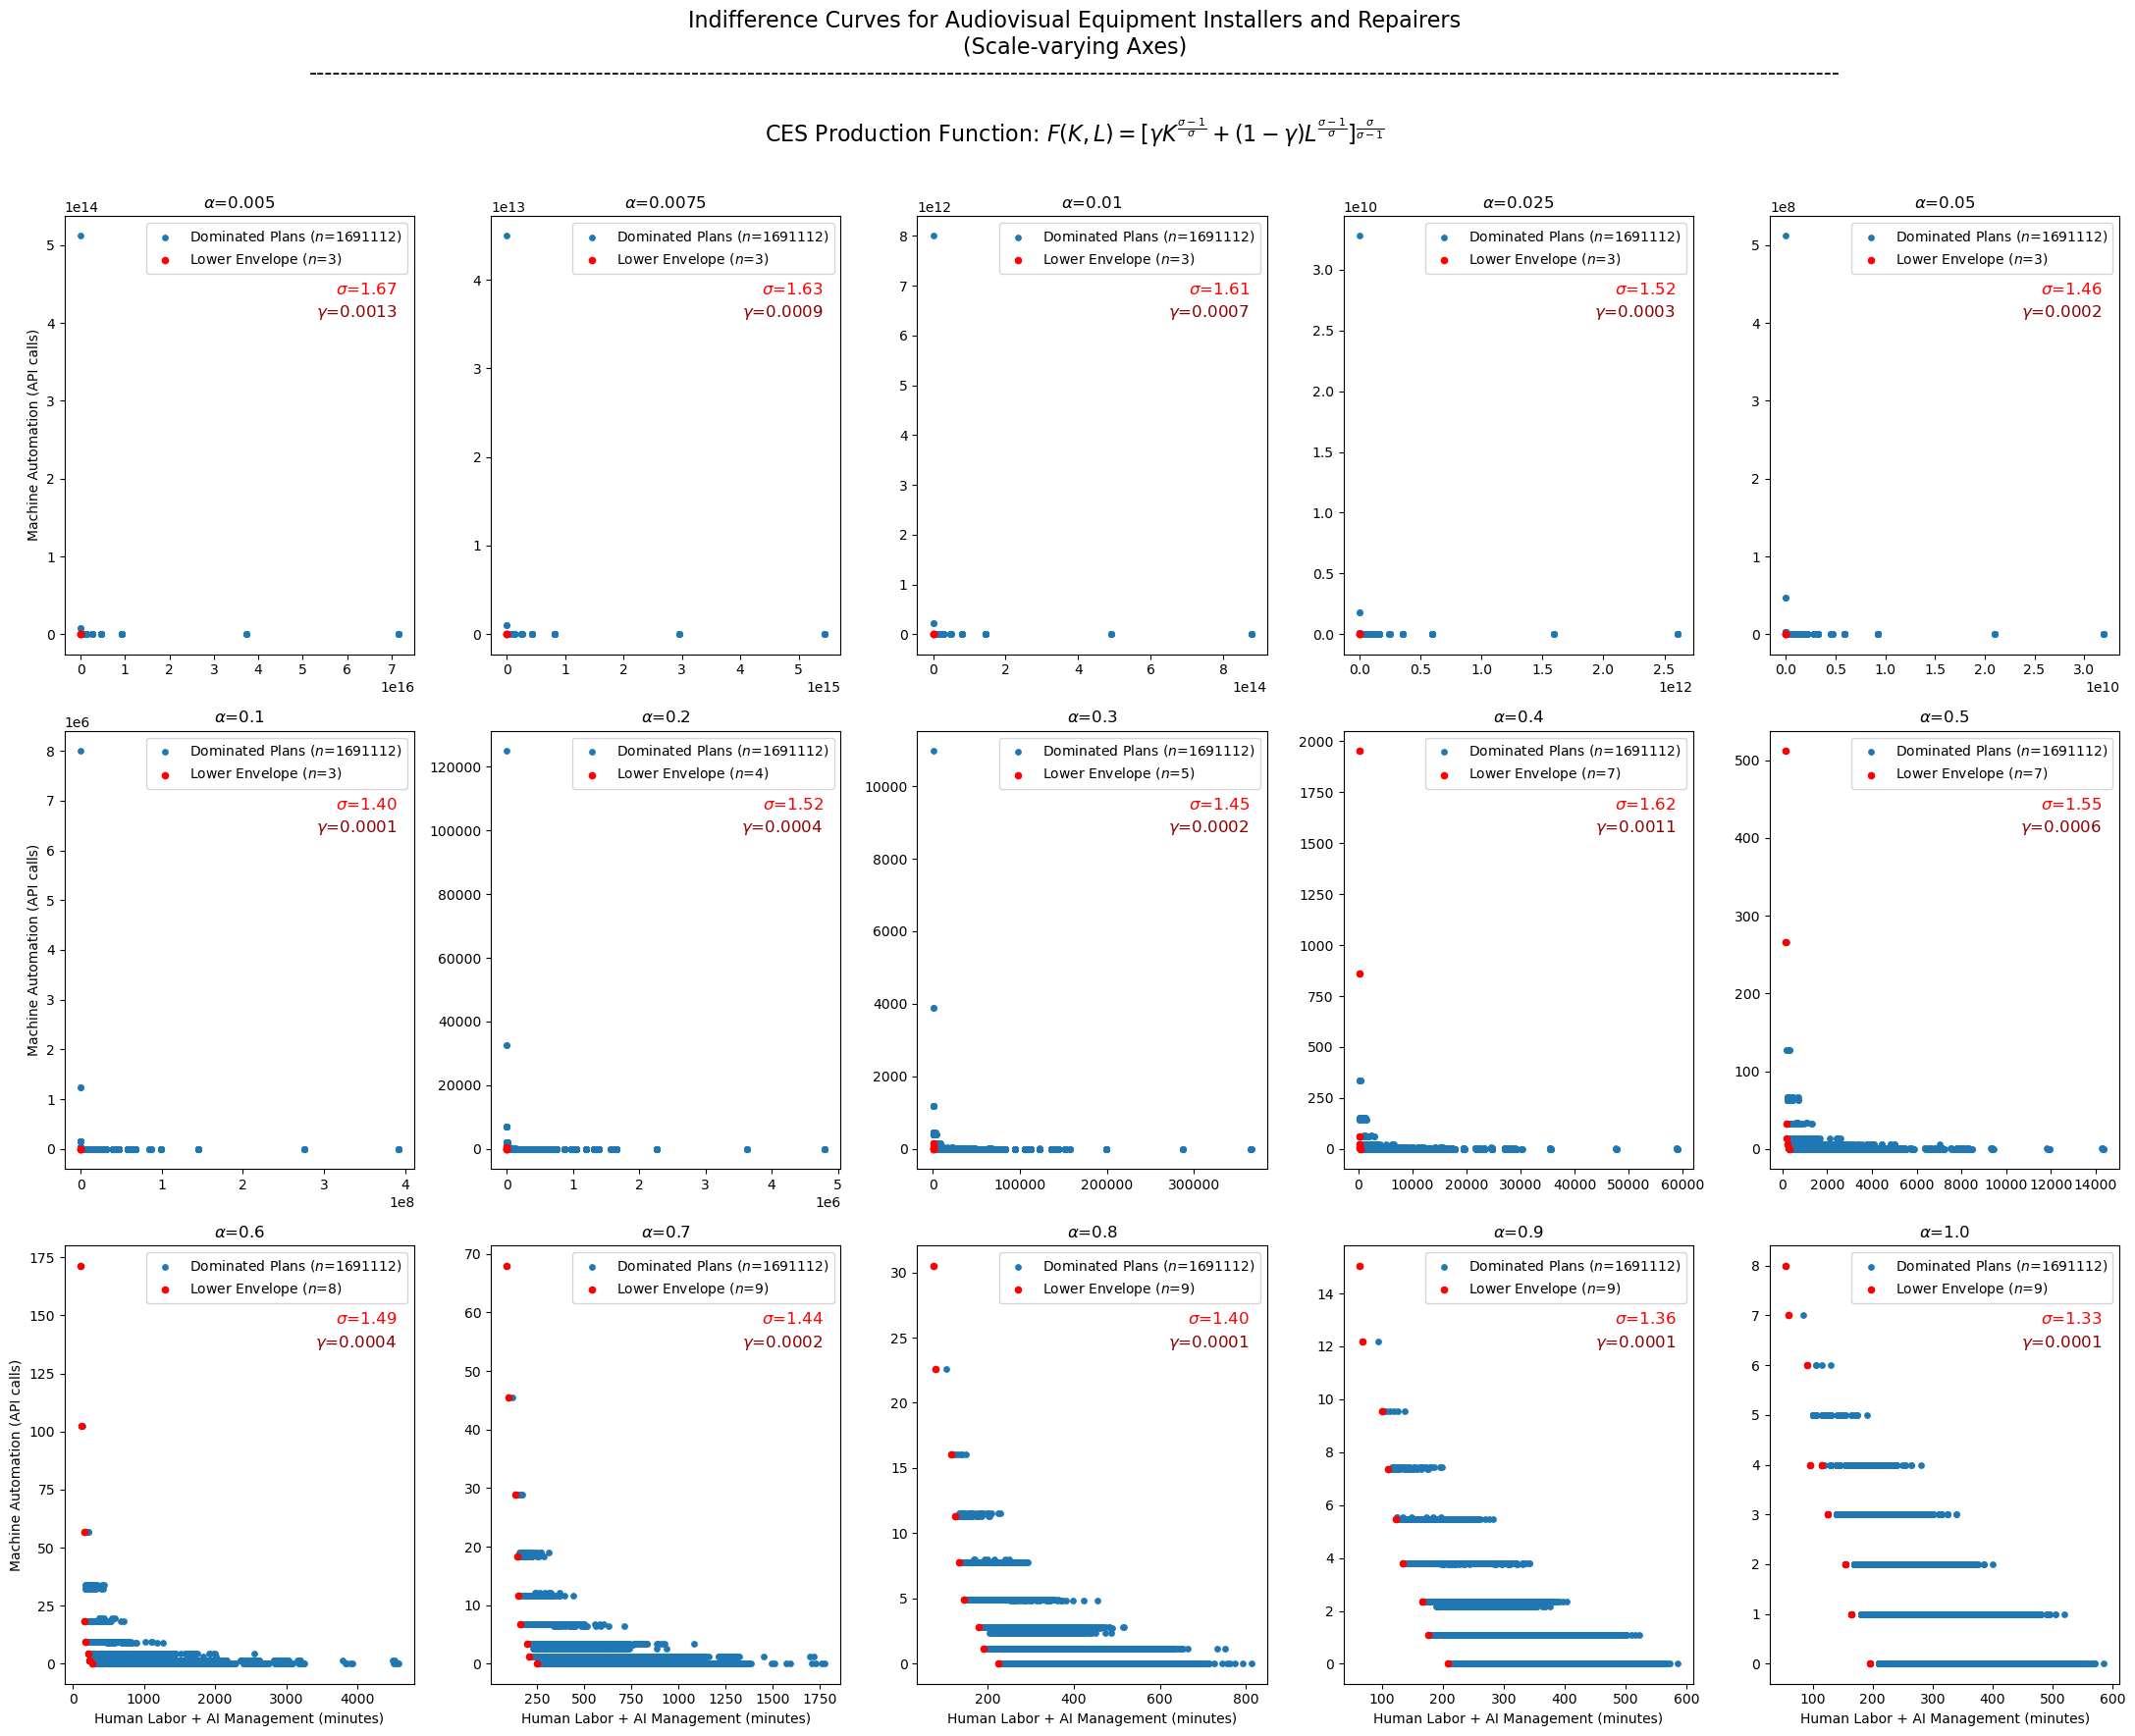

In [31]:
# Plot version 1a: no scaling with lower envelope points colored red - linear axes

# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(22, 18))

# Iterate over each subplot position and add a plot
for i in range(3): 
    for j in range(5): 
        alpha_index = (i % 5) * 5 + j
        my_alpha = alpha_list[alpha_index]

        # Plot all execution plans for given alpha
        my_alpha_indiff_df = indiff_df[indiff_df['alpha']==my_alpha]
        axs[i, j].scatter(my_alpha_indiff_df.labor_cost, my_alpha_indiff_df.automation_cost, 
                          s=15, 
                          label=f'Dominated Plans (' + r'$n$' + f'={my_alpha_indiff_df.shape[0]})')
        
        # Plot lower envelope points in red
        my_alpha_lower_envelope_df = lower_envelope_df[lower_envelope_df['alpha']==my_alpha]
        axs[i, j].scatter(my_alpha_lower_envelope_df.labor_cost, my_alpha_lower_envelope_df.automation_cost, 
                          s=20, 
                          color='red', 
                          label='Lower Envelope (' + r'$n$' + f'={my_alpha_lower_envelope_df.shape[0]})')
        
        # Add elasticity and labor share for current alpha
        my_alpha_sigma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'sigma'].values[0]
        my_alpha_gamma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'gamma'].values[0]
        
        sigma_display = r'$\sigma$' + f'={my_alpha_sigma:.2f}'
        gamma_display = r'$\gamma$' + f'={my_alpha_gamma:.4f}'
        axs[i, j].text(0.95, 0.85, sigma_display, transform=axs[i, j].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', color='red')
        axs[i, j].text(0.95, 0.8, gamma_display, transform=axs[i, j].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', color='darkred')
        
        # other plot aesthetics
        axs[i, j].title.set_text(r'$\alpha$' + f'={np.round(my_alpha,4)}')
        if i == 2:
              axs[i, j].set_xlabel('Human Labor + AI Management (minutes)')
        if j == 0:
              axs[i, j].set_ylabel('Machine Automation (API calls)')
        axs[i, j].legend(loc = 'upper right')

fig.suptitle(f'Indifference Curves for {plot_title_occupation}\n' +
             '(Scale-varying Axes)' +
             '\n' + 
            '------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n\n' + 
             r'CES Production Function: $F(K,L) = [\gamma K^{\frac{\sigma-1}{\sigma}} + (1-\gamma) L^{\frac{\sigma-1}{\sigma}}]^{\frac{\sigma}{\sigma-1}} $' + 
             '\n' +
             '\n',
             fontsize=16)

plt.tight_layout()

# Save the plot
plt.savefig(f'{occupation_folder}/indiffCurves/{occupation}_indiffCurves_linear_FLT.png', dpi=300)
# plt.savefig(f'{occupation}_indiffCurve_linear_FLT.png', dpi=300)

# Show plot
plt.show()

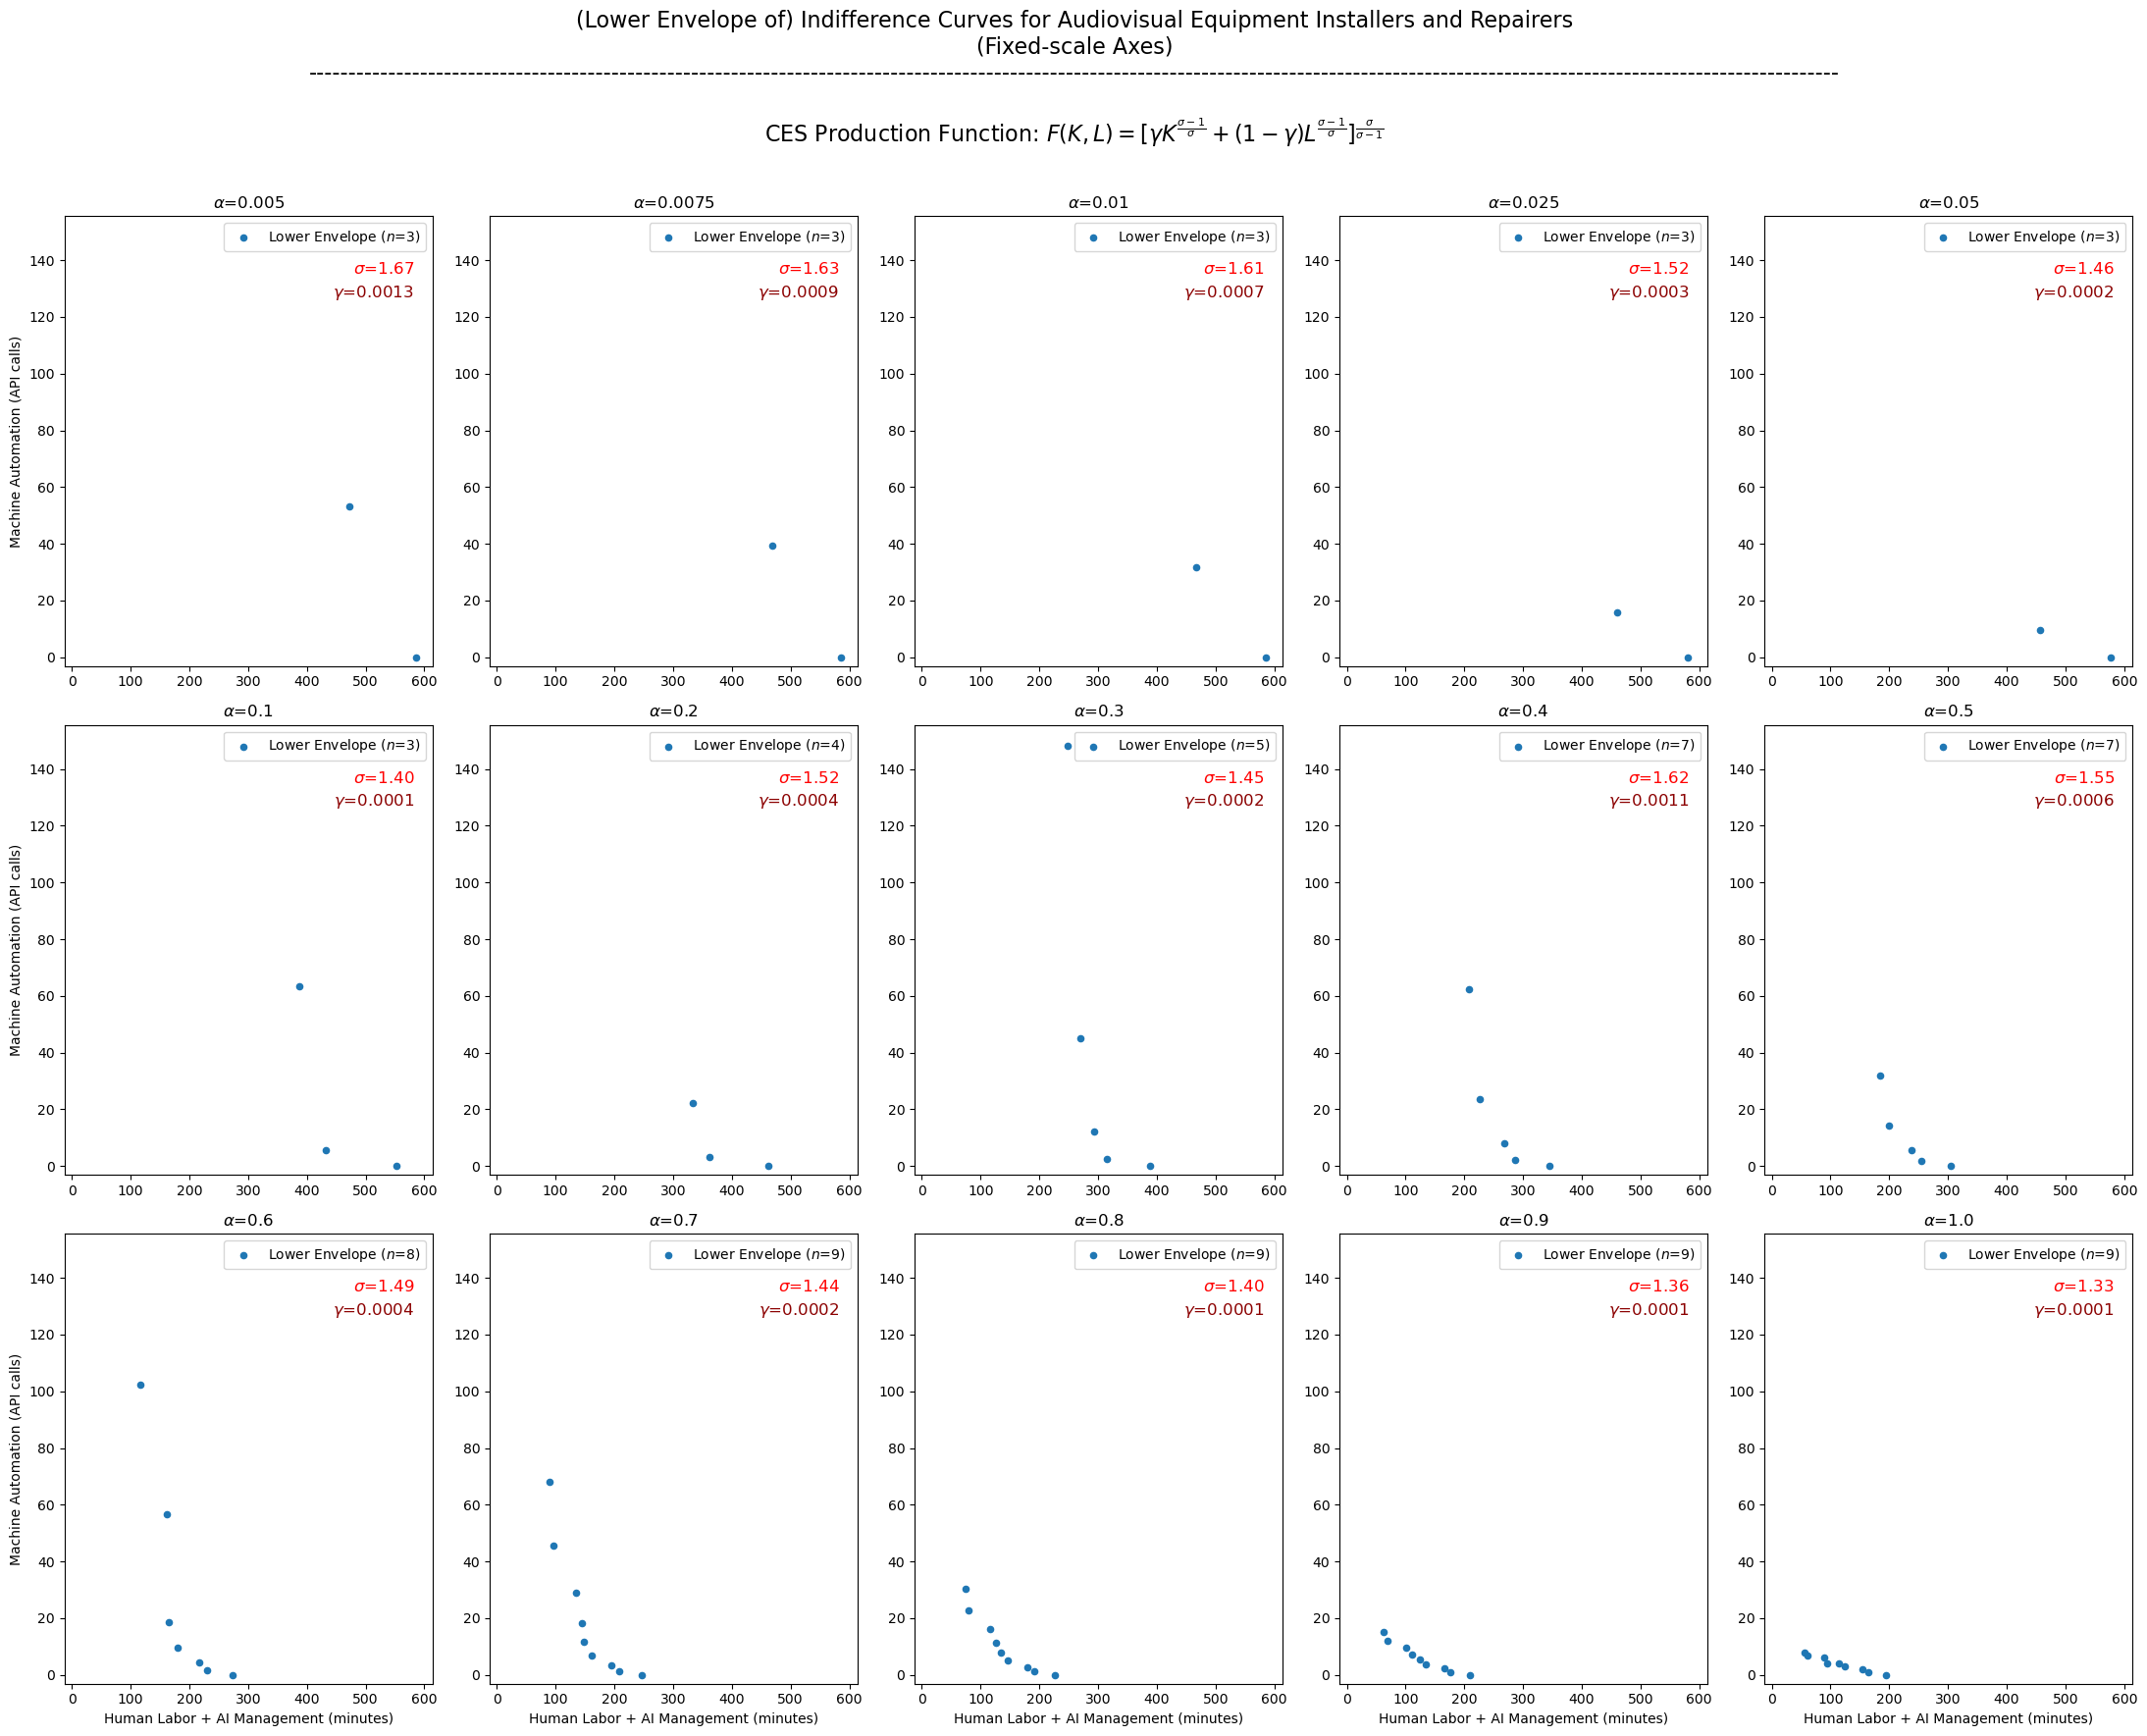

In [32]:
# Plot version 2a: scaling with only lower envelope points - linear axes

# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(22, 18))

# Iterate over each subplot position and add a plot
for i in range(3): 
    for j in range(5): 
        alpha_index = (i % 5) * 5 + j
        my_alpha = alpha_list[alpha_index]

        # Plot lower envelope points in red
        my_alpha_lower_envelope_df = lower_envelope_df[lower_envelope_df['alpha']==my_alpha]
        axs[i, j].scatter(my_alpha_lower_envelope_df.labor_cost, my_alpha_lower_envelope_df.automation_cost, 
                          s=20, 
                          label='Lower Envelope (' + r'$n$' + f'={my_alpha_lower_envelope_df.shape[0]})')
        
        # Add elasticity and labor share for current alpha
        my_alpha_sigma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'sigma'].values[0]
        my_alpha_gamma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'gamma'].values[0]
        
        sigma_display = r'$\sigma$' + f'={my_alpha_sigma:.2f}'
        gamma_display = r'$\gamma$' + f'={my_alpha_gamma:.4f}'
        axs[i, j].text(0.95, 0.9, sigma_display, transform=axs[i, j].transAxes, fontsize=12, 
                       verticalalignment='top', horizontalalignment='right', color='red')
        axs[i, j].text(0.95, 0.85, gamma_display, transform=axs[i, j].transAxes, fontsize=12, 
                       verticalalignment='top', horizontalalignment='right', color='darkred')
        
        # other plot aesthetics
        axs[i, j].title.set_text(r'$\alpha$' + f'={np.round(my_alpha,4)}')
        if i == 2:
              axs[i, j].set_xlabel('Human Labor + AI Management (minutes)')
        if j == 0:
              axs[i, j].set_ylabel('Machine Automation (API calls)')
        axs[i, j].legend(loc = 'upper right')

        # set x and y limits
        xh = lower_envelope_df[lower_envelope_df.alpha==alpha_list[0]]['labor_cost'].max() * 1.05
        xl = - xh / 50
        yh = lower_envelope_df[lower_envelope_df.alpha==0.3]['automation_cost'].max() * 1.05
        yl = - yh / 50
        
        axs[i, j].set_xlim(xl, xh)
        axs[i, j].set_ylim(yl, yh)

fig.suptitle(f'(Lower Envelope of) Indifference Curves for {plot_title_occupation}\n' +
             '(Fixed-scale Axes)' +
             '\n' + 
            '------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n\n' + 
             r'CES Production Function: $F(K,L) = [\gamma K^{\frac{\sigma-1}{\sigma}} + (1-\gamma) L^{\frac{\sigma-1}{\sigma}}]^{\frac{\sigma}{\sigma-1}} $' + 
             '\n' +
             '\n',
             fontsize=16)

plt.tight_layout()

# Save the plot
plt.savefig(f'{occupation_folder}/indiffCurves/{occupation}_indiffCurves_lowerEnv_linear_FLT.png', dpi=300)
# plt.savefig(f'{occupation}_indiffCurve_lowerEnv_linear_FLT.png', dpi=300)

# Show plot
plt.show()

### Log scale graphs

In [33]:
# # Plot version 1b: no scaling with lower envelope points colored red - log axes

# # Create a 3x5 grid of subplots
# fig, axs = plt.subplots(3, 5, figsize=(22, 18))

# # Iterate over each subplot position and add a plot
# for i in range(3): 
#     for j in range(5): 
#         alpha_index = (i % 5) * 5 + j
#         my_alpha = alpha_list[alpha_index]

#         # Plot all execution plans for given alpha
#         my_alpha_indiff_df = indiff_df[indiff_df['alpha']==my_alpha]

#         # convert scale to log
#         my_alpha_indiff_df['labor_cost'] = np.log1p(my_alpha_indiff_df['labor_cost'])
#         my_alpha_indiff_df['automation_cost'] = np.log1p(my_alpha_indiff_df['automation_cost'])

#         axs[i, j].scatter(my_alpha_indiff_df.labor_cost, my_alpha_indiff_df.automation_cost, 
#                           s=15, 
#                           label=f'Dominated Plans (' + r'$n$' + f'={my_alpha_indiff_df.shape[0]})')
        
#         # Plot lower envelope points in red
#         my_alpha_lower_envelope_df = lower_envelope_df[lower_envelope_df['alpha']==my_alpha]

#         # convert scale to log
#         my_alpha_lower_envelope_df['labor_cost'] = np.log1p(my_alpha_lower_envelope_df['labor_cost'])
#         my_alpha_lower_envelope_df['automation_cost'] = np.log1p(my_alpha_lower_envelope_df['automation_cost'])

#         axs[i, j].scatter(my_alpha_lower_envelope_df.labor_cost, my_alpha_lower_envelope_df.automation_cost, 
#                           s=20, 
#                           color='red', 
#                           label='Lower Envelope (' + r'$n$' + f'={my_alpha_lower_envelope_df.shape[0]})')
        
#         # Add elasticity and labor share for current alpha
#         my_alpha_sigma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'sigma'].values[0]
#         my_alpha_gamma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'gamma'].values[0]
        
#         sigma_display = r'$\sigma$' + f'={my_alpha_sigma:.2f}'
#         gamma_display = r'$\gamma$' + f'={my_alpha_gamma:.4f}'
#         axs[i, j].text(0.95, 0.85, sigma_display, transform=axs[i, j].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', color='red')
#         axs[i, j].text(0.95, 0.8, gamma_display, transform=axs[i, j].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', color='darkred')
        
#         # other plot aesthetics
#         axs[i, j].title.set_text(r'$\alpha$' + f'={np.round(my_alpha,4)}')
#         if i == 2:
#               axs[i, j].set_xlabel('Human Labor + AI Management (log minutes)')
#         if j == 0:
#               axs[i, j].set_ylabel('Machine Automation (log API calls)')
#         axs[i, j].legend(loc = 'upper right')

# fig.suptitle(f'Indifference Curves for {plot_title_occupation}: First-Last-Task DAG\n' +
#              '(Scale-varying Axes in logs)' +
#              '\n' + 
#             '------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n\n' + 
#              r'CES Production Function: $F(K,L) = [\gamma K^{\frac{\sigma-1}{\sigma}} + (1-\gamma) L^{\frac{\sigma-1}{\sigma}}]^{\frac{\sigma}{\sigma-1}} $' + 
#              '\n' +
#              '\n',
#              fontsize=16)

# plt.tight_layout()

# # Save the plot
# # plt.savefig(f'{occupation_folder}/indiffCurves/{occupation}_indiffCurves_log_FLT.png', dpi=300)
# # plt.savefig(f'{occupation}_indiffCurve_log_FLT.png', dpi=300)

# # Show plot
# plt.show()

In [34]:
# # Plot version 2a: scaling with only lower envelope points - log axes

# # Create a 3x5 grid of subplots
# fig, axs = plt.subplots(3, 5, figsize=(22, 18))

# # Iterate over each subplot position and add a plot
# for i in range(3): 
#     for j in range(5): 
#         alpha_index = (i % 5) * 5 + j
#         my_alpha = alpha_list[alpha_index]

#         # Plot lower envelope points in red
#         my_alpha_lower_envelope_df = lower_envelope_df[lower_envelope_df['alpha']==my_alpha]

#         # convert scale to log
#         my_alpha_lower_envelope_df['labor_cost'] = np.log(my_alpha_lower_envelope_df['labor_cost']+epsilon)
#         my_alpha_lower_envelope_df['automation_cost'] = np.log(my_alpha_lower_envelope_df['automation_cost']+epsilon)

#         axs[i, j].scatter(my_alpha_lower_envelope_df.labor_cost, my_alpha_lower_envelope_df.automation_cost, 
#                           s=20, 
#                           label='Lower Envelope (' + r'$n$' + f'={my_alpha_lower_envelope_df.shape[0]})')
        
#         # Add elasticity and labor share for current alpha
#         my_alpha_sigma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'sigma'].values[0]
#         my_alpha_gamma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'gamma'].values[0]
        
#         sigma_display = r'$\sigma$' + f'={my_alpha_sigma:.2f}'
#         gamma_display = r'$\gamma$' + f'={my_alpha_gamma:.4f}'
#         axs[i, j].text(0.95, 0.9, sigma_display, transform=axs[i, j].transAxes, fontsize=12, 
#                        verticalalignment='top', horizontalalignment='right', color='red')
#         axs[i, j].text(0.95, 0.85, gamma_display, transform=axs[i, j].transAxes, fontsize=12, 
#                        verticalalignment='top', horizontalalignment='right', color='darkred')
        
#         # other plot aesthetics
#         axs[i, j].title.set_text(r'$\alpha$' + f'={np.round(my_alpha,4)}')
#         if i == 2:
#               axs[i, j].set_xlabel('Human Labor + AI Management (log minutes)')
#         if j == 0:
#               axs[i, j].set_ylabel('Machine Automation (log API calls)')
#         axs[i, j].legend(loc = 'upper right')

#         # set x and y limits
#         axs[i, j].set_xlim(-0.5, 7)
#         axs[i, j].set_ylim(-2, 20)


# fig.suptitle(f'(Lower Envelope of) Indifference Curves for {plot_title_occupation}: First-Last-Task DAG\n' +
#              '(Fixed-scale Axes in logs)' +
#              '\n' + 
#             '------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n\n' + 
#              r'CES Production Function: $F(K,L) = [\gamma K^{\frac{\sigma-1}{\sigma}} + (1-\gamma) L^{\frac{\sigma-1}{\sigma}}]^{\frac{\sigma}{\sigma-1}} $' + 
#              '\n' +
#              '\n',
#              fontsize=16)

# plt.tight_layout()

# # Save the plot
# # plt.savefig(f'{occupation_folder}/indiffCurves/{occupation}_indiffCurves_lowerEnv_log_FLT.png', dpi=300)
# # plt.savefig(f'{occupation}_indiffCurve_lowerEnv_log_FLT.png', dpi=300)

# # Show plot
# plt.show()